# Training with Data Augmentation and some improving

I try to increase the number of raspberry samples, dubling it.

I change the architecture of the network adding L2 regularization and some more layers.

I will let the early stopping go for 15 epochs.

I changed the background color of 50% of images in rgb: 189,189,189


In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Doubled the number of raspebrry in this dataset
!unzip ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/no_tomato_raspb_x2.zip

In [ ]:
%cd /content

/content


#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'no_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

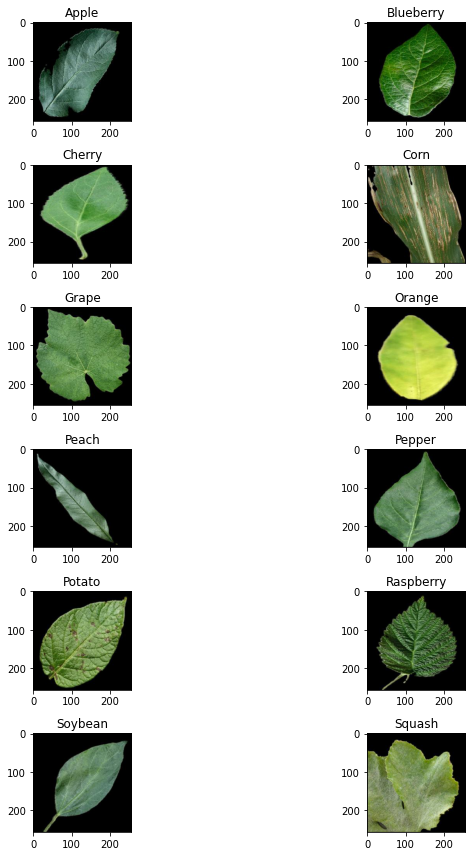

In [ ]:
# Plot example images from dataset
labels = labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))

for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

#Data Generator

Import:

In [ ]:
cd /content

/content


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
from random import randint

def change_color(image):
    image = np.array(image)
    if random.random() > 0.5:
      image[image[:, :, 0] <= 10] = 189
    return image

# Create an instance of ImageDataGenerator with Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0, rescale=1/255., preprocessing_function=change_color)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)


Found 9220 images belonging to 13 classes.
Found 1799 images belonging to 13 classes.
Found 1214 images belonging to 13 classes.


# Check example - Data Augmentation

In [ ]:
image = next(noaug_train_gen)[0]


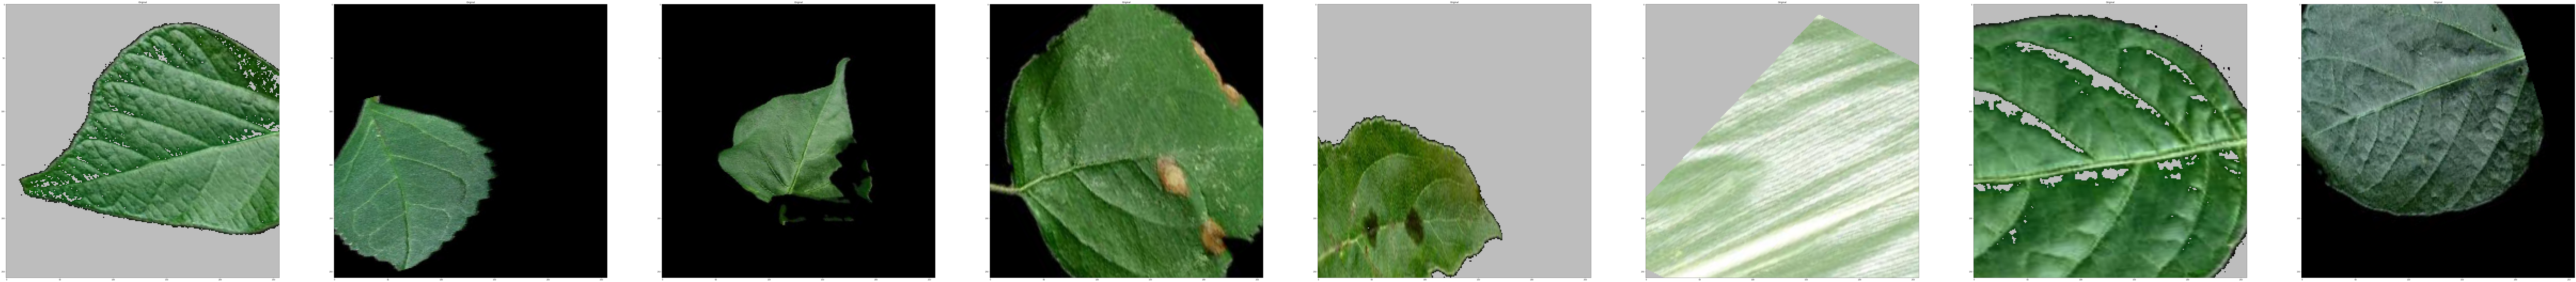

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(255, 255))
init = 0
for i in range(init, init+8):
  ax[i-init].imshow(np.array(image[i]))
  ax[i-init].set_title('Original')

In [ ]:
print(image[0].shape)

(256, 256, 3)


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model used:
# Network leyout changed as described above
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1_2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1_2)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2_2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2_2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-4), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=13, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0003), metrics=[tf.keras.metrics.CategoricalAccuracy(), 'accuracy'])

    # Return the model
    return model

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      9248      
                                                             

# Save checkpoints

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Training the model

In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='v4_DA_no_tomato')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
577/577 [==============================] - ETA: 0s - loss: 2.4404 - categorical_accuracy: 0.1595 - accuracy: 0.1595

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 133s 202ms/step - loss: 2.4404 - categorical_accuracy: 0.1595 - accuracy: 0.1595 - val_loss: 2.3690 - val_categorical_accuracy: 0.2112 - val_accuracy: 0.2112
Epoch 2/200
577/577 [==============================] - ETA: 0s - loss: 2.1496 - categorical_accuracy: 0.2838 - accuracy: 0.2838

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 2.1496 - categorical_accuracy: 0.2838 - accuracy: 0.2838 - val_loss: 2.0141 - val_categorical_accuracy: 0.3602 - val_accuracy: 0.3602
Epoch 3/200
577/577 [==============================] - ETA: 0s - loss: 1.8890 - categorical_accuracy: 0.3762 - accuracy: 0.3762

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 115s 199ms/step - loss: 1.8890 - categorical_accuracy: 0.3762 - accuracy: 0.3762 - val_loss: 1.7603 - val_categorical_accuracy: 0.4158 - val_accuracy: 0.4158
Epoch 4/200
577/577 [==============================] - ETA: 0s - loss: 1.6773 - categorical_accuracy: 0.4454 - accuracy: 0.4454

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 1.6773 - categorical_accuracy: 0.4454 - accuracy: 0.4454 - val_loss: 1.5029 - val_categorical_accuracy: 0.4786 - val_accuracy: 0.4786
Epoch 5/200
577/577 [==============================] - ETA: 0s - loss: 1.5412 - categorical_accuracy: 0.4931 - accuracy: 0.4931

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 1.5412 - categorical_accuracy: 0.4931 - accuracy: 0.4931 - val_loss: 1.4363 - val_categorical_accuracy: 0.5231 - val_accuracy: 0.5231
Epoch 6/200
577/577 [==============================] - ETA: 0s - loss: 1.4728 - categorical_accuracy: 0.5234 - accuracy: 0.5234

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 1.4728 - categorical_accuracy: 0.5234 - accuracy: 0.5234 - val_loss: 1.3595 - val_categorical_accuracy: 0.5603 - val_accuracy: 0.5603
Epoch 7/200
577/577 [==============================] - ETA: 0s - loss: 1.3153 - categorical_accuracy: 0.5743 - accuracy: 0.5743

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 115s 199ms/step - loss: 1.3153 - categorical_accuracy: 0.5743 - accuracy: 0.5743 - val_loss: 1.0675 - val_categorical_accuracy: 0.6559 - val_accuracy: 0.6559
Epoch 8/200
577/577 [==============================] - ETA: 0s - loss: 1.2019 - categorical_accuracy: 0.6084 - accuracy: 0.6084

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 1.2019 - categorical_accuracy: 0.6084 - accuracy: 0.6084 - val_loss: 1.3863 - val_categorical_accuracy: 0.5670 - val_accuracy: 0.5670
Epoch 9/200
577/577 [==============================] - ETA: 0s - loss: 1.1405 - categorical_accuracy: 0.6376 - accuracy: 0.6376

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 1.1405 - categorical_accuracy: 0.6376 - accuracy: 0.6376 - val_loss: 0.9157 - val_categorical_accuracy: 0.7015 - val_accuracy: 0.7015
Epoch 10/200
577/577 [==============================] - ETA: 0s - loss: 1.0339 - categorical_accuracy: 0.6761 - accuracy: 0.6761

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 1.0339 - categorical_accuracy: 0.6761 - accuracy: 0.6761 - val_loss: 1.6242 - val_categorical_accuracy: 0.5548 - val_accuracy: 0.5548
Epoch 11/200
577/577 [==============================] - ETA: 0s - loss: 1.0205 - categorical_accuracy: 0.6826 - accuracy: 0.6826

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 1.0205 - categorical_accuracy: 0.6826 - accuracy: 0.6826 - val_loss: 0.8933 - val_categorical_accuracy: 0.7215 - val_accuracy: 0.7215
Epoch 12/200
577/577 [==============================] - ETA: 0s - loss: 0.9614 - categorical_accuracy: 0.6995 - accuracy: 0.6995

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.9614 - categorical_accuracy: 0.6995 - accuracy: 0.6995 - val_loss: 0.8125 - val_categorical_accuracy: 0.7365 - val_accuracy: 0.7365
Epoch 13/200
577/577 [==============================] - ETA: 0s - loss: 0.9253 - categorical_accuracy: 0.7130 - accuracy: 0.7130

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.9253 - categorical_accuracy: 0.7130 - accuracy: 0.7130 - val_loss: 0.7788 - val_categorical_accuracy: 0.7554 - val_accuracy: 0.7554
Epoch 14/200
577/577 [==============================] - ETA: 0s - loss: 0.8740 - categorical_accuracy: 0.7299 - accuracy: 0.7299

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.8740 - categorical_accuracy: 0.7299 - accuracy: 0.7299 - val_loss: 0.8112 - val_categorical_accuracy: 0.7415 - val_accuracy: 0.7415
Epoch 15/200
577/577 [==============================] - ETA: 0s - loss: 0.8384 - categorical_accuracy: 0.7452 - accuracy: 0.7452

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.8384 - categorical_accuracy: 0.7452 - accuracy: 0.7452 - val_loss: 0.6523 - val_categorical_accuracy: 0.7988 - val_accuracy: 0.7988
Epoch 16/200
577/577 [==============================] - ETA: 0s - loss: 0.7871 - categorical_accuracy: 0.7628 - accuracy: 0.7628

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 113s 196ms/step - loss: 0.7871 - categorical_accuracy: 0.7628 - accuracy: 0.7628 - val_loss: 0.5472 - val_categorical_accuracy: 0.8355 - val_accuracy: 0.8355
Epoch 17/200
577/577 [==============================] - ETA: 0s - loss: 0.7667 - categorical_accuracy: 0.7727 - accuracy: 0.7727

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.7667 - categorical_accuracy: 0.7727 - accuracy: 0.7727 - val_loss: 0.5772 - val_categorical_accuracy: 0.8305 - val_accuracy: 0.8305
Epoch 18/200
577/577 [==============================] - ETA: 0s - loss: 0.7472 - categorical_accuracy: 0.7807 - accuracy: 0.7807

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.7472 - categorical_accuracy: 0.7807 - accuracy: 0.7807 - val_loss: 0.5697 - val_categorical_accuracy: 0.8327 - val_accuracy: 0.8327
Epoch 19/200
577/577 [==============================] - ETA: 0s - loss: 0.7013 - categorical_accuracy: 0.7933 - accuracy: 0.7933

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.7013 - categorical_accuracy: 0.7933 - accuracy: 0.7933 - val_loss: 0.5116 - val_categorical_accuracy: 0.8560 - val_accuracy: 0.8560
Epoch 20/200
577/577 [==============================] - ETA: 0s - loss: 0.6799 - categorical_accuracy: 0.8037 - accuracy: 0.8037

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.6799 - categorical_accuracy: 0.8037 - accuracy: 0.8037 - val_loss: 0.5678 - val_categorical_accuracy: 0.8344 - val_accuracy: 0.8344
Epoch 21/200
577/577 [==============================] - ETA: 0s - loss: 0.6614 - categorical_accuracy: 0.8062 - accuracy: 0.8062

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.6614 - categorical_accuracy: 0.8062 - accuracy: 0.8062 - val_loss: 0.5993 - val_categorical_accuracy: 0.8471 - val_accuracy: 0.8471
Epoch 22/200
577/577 [==============================] - ETA: 0s - loss: 0.6263 - categorical_accuracy: 0.8166 - accuracy: 0.8166

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.6263 - categorical_accuracy: 0.8166 - accuracy: 0.8166 - val_loss: 0.5987 - val_categorical_accuracy: 0.8271 - val_accuracy: 0.8271
Epoch 23/200
577/577 [==============================] - ETA: 0s - loss: 0.6313 - categorical_accuracy: 0.8232 - accuracy: 0.8232

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 113s 196ms/step - loss: 0.6313 - categorical_accuracy: 0.8232 - accuracy: 0.8232 - val_loss: 0.4158 - val_categorical_accuracy: 0.8949 - val_accuracy: 0.8949
Epoch 24/200
577/577 [==============================] - ETA: 0s - loss: 0.5939 - categorical_accuracy: 0.8367 - accuracy: 0.8367

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.5939 - categorical_accuracy: 0.8367 - accuracy: 0.8367 - val_loss: 0.5193 - val_categorical_accuracy: 0.8533 - val_accuracy: 0.8533
Epoch 25/200
577/577 [==============================] - ETA: 0s - loss: 0.5750 - categorical_accuracy: 0.8363 - accuracy: 0.8363

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.5750 - categorical_accuracy: 0.8363 - accuracy: 0.8363 - val_loss: 0.5008 - val_categorical_accuracy: 0.8610 - val_accuracy: 0.8610
Epoch 26/200
577/577 [==============================] - ETA: 0s - loss: 0.5425 - categorical_accuracy: 0.8524 - accuracy: 0.8524

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.5425 - categorical_accuracy: 0.8524 - accuracy: 0.8524 - val_loss: 0.4112 - val_categorical_accuracy: 0.8877 - val_accuracy: 0.8877
Epoch 27/200
577/577 [==============================] - ETA: 0s - loss: 0.5390 - categorical_accuracy: 0.8520 - accuracy: 0.8520

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.5390 - categorical_accuracy: 0.8520 - accuracy: 0.8520 - val_loss: 0.3527 - val_categorical_accuracy: 0.9072 - val_accuracy: 0.9072
Epoch 28/200
577/577 [==============================] - ETA: 0s - loss: 0.5223 - categorical_accuracy: 0.8613 - accuracy: 0.8613

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 115s 199ms/step - loss: 0.5223 - categorical_accuracy: 0.8613 - accuracy: 0.8613 - val_loss: 0.4816 - val_categorical_accuracy: 0.8738 - val_accuracy: 0.8738
Epoch 29/200
577/577 [==============================] - ETA: 0s - loss: 0.5299 - categorical_accuracy: 0.8569 - accuracy: 0.8569

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 115s 199ms/step - loss: 0.5299 - categorical_accuracy: 0.8569 - accuracy: 0.8569 - val_loss: 0.3171 - val_categorical_accuracy: 0.9311 - val_accuracy: 0.9311
Epoch 30/200
577/577 [==============================] - ETA: 0s - loss: 0.4823 - categorical_accuracy: 0.8706 - accuracy: 0.8706

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4823 - categorical_accuracy: 0.8706 - accuracy: 0.8706 - val_loss: 0.4332 - val_categorical_accuracy: 0.8966 - val_accuracy: 0.8966
Epoch 31/200
577/577 [==============================] - ETA: 0s - loss: 0.4962 - categorical_accuracy: 0.8693 - accuracy: 0.8693

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4962 - categorical_accuracy: 0.8693 - accuracy: 0.8693 - val_loss: 0.2946 - val_categorical_accuracy: 0.9305 - val_accuracy: 0.9305
Epoch 32/200
577/577 [==============================] - ETA: 0s - loss: 0.4731 - categorical_accuracy: 0.8754 - accuracy: 0.8754

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4731 - categorical_accuracy: 0.8754 - accuracy: 0.8754 - val_loss: 0.2921 - val_categorical_accuracy: 0.9255 - val_accuracy: 0.9255
Epoch 33/200
577/577 [==============================] - ETA: 0s - loss: 0.4793 - categorical_accuracy: 0.8735 - accuracy: 0.8735

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4793 - categorical_accuracy: 0.8735 - accuracy: 0.8735 - val_loss: 0.4550 - val_categorical_accuracy: 0.8805 - val_accuracy: 0.8805
Epoch 34/200
577/577 [==============================] - ETA: 0s - loss: 0.4637 - categorical_accuracy: 0.8783 - accuracy: 0.8783

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4637 - categorical_accuracy: 0.8783 - accuracy: 0.8783 - val_loss: 0.2598 - val_categorical_accuracy: 0.9411 - val_accuracy: 0.9411
Epoch 35/200
577/577 [==============================] - ETA: 0s - loss: 0.4660 - categorical_accuracy: 0.8791 - accuracy: 0.8791

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4660 - categorical_accuracy: 0.8791 - accuracy: 0.8791 - val_loss: 0.3155 - val_categorical_accuracy: 0.9316 - val_accuracy: 0.9316
Epoch 36/200
577/577 [==============================] - ETA: 0s - loss: 0.4605 - categorical_accuracy: 0.8798 - accuracy: 0.8798

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 113s 196ms/step - loss: 0.4605 - categorical_accuracy: 0.8798 - accuracy: 0.8798 - val_loss: 0.2968 - val_categorical_accuracy: 0.9305 - val_accuracy: 0.9305
Epoch 37/200
577/577 [==============================] - ETA: 0s - loss: 0.4392 - categorical_accuracy: 0.8903 - accuracy: 0.8903

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4392 - categorical_accuracy: 0.8903 - accuracy: 0.8903 - val_loss: 0.4462 - val_categorical_accuracy: 0.8844 - val_accuracy: 0.8844
Epoch 38/200
577/577 [==============================] - ETA: 0s - loss: 0.4369 - categorical_accuracy: 0.8913 - accuracy: 0.8913

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4369 - categorical_accuracy: 0.8913 - accuracy: 0.8913 - val_loss: 0.3639 - val_categorical_accuracy: 0.9055 - val_accuracy: 0.9055
Epoch 39/200
577/577 [==============================] - ETA: 0s - loss: 0.4191 - categorical_accuracy: 0.8936 - accuracy: 0.8936

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4191 - categorical_accuracy: 0.8936 - accuracy: 0.8936 - val_loss: 0.4467 - val_categorical_accuracy: 0.8994 - val_accuracy: 0.8994
Epoch 40/200
577/577 [==============================] - ETA: 0s - loss: 0.4248 - categorical_accuracy: 0.8896 - accuracy: 0.8896

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.4248 - categorical_accuracy: 0.8896 - accuracy: 0.8896 - val_loss: 0.2841 - val_categorical_accuracy: 0.9400 - val_accuracy: 0.9400
Epoch 41/200
577/577 [==============================] - ETA: 0s - loss: 0.4039 - categorical_accuracy: 0.8997 - accuracy: 0.8997

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.4039 - categorical_accuracy: 0.8997 - accuracy: 0.8997 - val_loss: 0.2946 - val_categorical_accuracy: 0.9355 - val_accuracy: 0.9355
Epoch 42/200
577/577 [==============================] - ETA: 0s - loss: 0.4083 - categorical_accuracy: 0.8958 - accuracy: 0.8958

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4083 - categorical_accuracy: 0.8958 - accuracy: 0.8958 - val_loss: 0.8136 - val_categorical_accuracy: 0.8455 - val_accuracy: 0.8455
Epoch 43/200
577/577 [==============================] - ETA: 0s - loss: 0.4118 - categorical_accuracy: 0.8991 - accuracy: 0.8991

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.4118 - categorical_accuracy: 0.8991 - accuracy: 0.8991 - val_loss: 0.3827 - val_categorical_accuracy: 0.9111 - val_accuracy: 0.9111
Epoch 44/200
577/577 [==============================] - ETA: 0s - loss: 0.3874 - categorical_accuracy: 0.9034 - accuracy: 0.9034

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.3874 - categorical_accuracy: 0.9034 - accuracy: 0.9034 - val_loss: 0.4470 - val_categorical_accuracy: 0.8988 - val_accuracy: 0.8988
Epoch 45/200
577/577 [==============================] - ETA: 0s - loss: 0.4032 - categorical_accuracy: 0.8962 - accuracy: 0.8962

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.4032 - categorical_accuracy: 0.8962 - accuracy: 0.8962 - val_loss: 0.3097 - val_categorical_accuracy: 0.9300 - val_accuracy: 0.9300
Epoch 46/200
577/577 [==============================] - ETA: 0s - loss: 0.3637 - categorical_accuracy: 0.9108 - accuracy: 0.9108

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.3637 - categorical_accuracy: 0.9108 - accuracy: 0.9108 - val_loss: 0.2918 - val_categorical_accuracy: 0.9394 - val_accuracy: 0.9394
Epoch 47/200
577/577 [==============================] - ETA: 0s - loss: 0.3917 - categorical_accuracy: 0.9049 - accuracy: 0.9049

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.3917 - categorical_accuracy: 0.9049 - accuracy: 0.9049 - val_loss: 0.3231 - val_categorical_accuracy: 0.9333 - val_accuracy: 0.9333
Epoch 48/200
577/577 [==============================] - ETA: 0s - loss: 0.3763 - categorical_accuracy: 0.9099 - accuracy: 0.9099

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 197ms/step - loss: 0.3763 - categorical_accuracy: 0.9099 - accuracy: 0.9099 - val_loss: 0.3943 - val_categorical_accuracy: 0.9194 - val_accuracy: 0.9194
Epoch 49/200
577/577 [==============================] - ETA: 0s - loss: 0.3652 - categorical_accuracy: 0.9098 - accuracy: 0.9098

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v4_DA_no_tomato_Nov19_17-55-55/ckpts/cp.ckpt/assets


577/577 [==============================] - 114s 198ms/step - loss: 0.3652 - categorical_accuracy: 0.9098 - accuracy: 0.9098 - val_loss: 0.2746 - val_categorical_accuracy: 0.9483 - val_accuracy: 0.9483


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN


In [ ]:
# Save best epoch model
model.save("Data_Augmentation_no_tomato_v44")

INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v4/assets


INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v4/assets


#Plot training error and validation error

{'loss': [2.4403774738311768, 2.149580717086792, 1.8890292644500732, 1.6773481369018555, 1.5411789417266846, 1.4728456735610962, 1.3153464794158936, 1.2019482851028442, 1.140533685684204, 1.0338903665542603, 1.0204929113388062, 0.9614414572715759, 0.9253271818161011, 0.873985767364502, 0.8383648991584778, 0.7870525121688843, 0.7666793465614319, 0.7471815943717957, 0.7012943029403687, 0.6799089908599854, 0.6613675355911255, 0.6262545585632324, 0.6312547922134399, 0.5938886404037476, 0.5749965310096741, 0.5425082445144653, 0.5389979481697083, 0.5222806334495544, 0.5298793911933899, 0.48234185576438904, 0.4962083399295807, 0.4731006920337677, 0.4792853891849518, 0.46366164088249207, 0.4660164713859558, 0.46045029163360596, 0.4391971826553345, 0.43690094351768494, 0.4191320240497589, 0.42478057742118835, 0.4039420187473297, 0.40828898549079895, 0.41177353262901306, 0.38741156458854675, 0.40320879220962524, 0.36373981833457947, 0.39173537492752075, 0.37634119391441345, 0.36521220207214355],

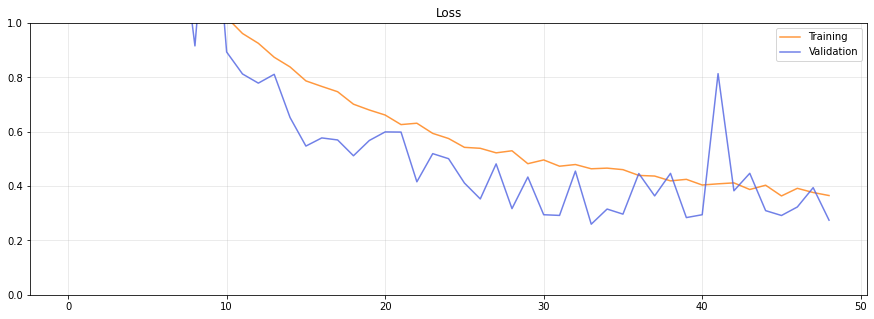

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Show predictions

In [ ]:
model_others = tfk.models.load_model("Data_Augmentation_no_tomato_v4")

In [ ]:
print(test_gen.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12}


In [ ]:
cd /content

/content


In [ ]:
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)

Found 1214 images belonging to 13 classes.


In [ ]:
model_metrics = model_others.evaluate(test_gen, return_dict=True)
print(model_metrics)

1214/1214 [==============================] - 20s 10ms/step - loss: 0.2254 - categorical_accuracy: 0.9547 - accuracy: 0.9547
{'loss': 0.22542010247707367, 'categorical_accuracy': 0.9546952247619629, 'accuracy': 0.9546952247619629}


In [ ]:
print(model_metrics['categorical_accuracy'])
predictions = model_others.predict_generator(test_gen, steps=1214)


0.9546952247619629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
ok = [0]*15
error = [0]*15

for i in range(0, 1214):
  for k in range(0,13):
    if(predictions[i][k] == max(predictions[i])):
      if true_classes[i] == k:
        ok[k] += 1
      else:
        error[k] += 1
print("ok:", ok)
print("error:", error)

ok: [92, 47, 50, 116, 145, 172, 94, 76, 66, 27, 154, 55, 61, 0, 0]
error: [4, 1, 3, 1, 13, 4, 1, 4, 0, 7, 2, 0, 4, 0, 0]


In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   
print(true_classes)

[ 0  0  0 ... 12 12 12]


In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

       Apple       0.95      0.93      0.94        99
   Blueberry       0.98      1.00      0.99        47
      Cherry       0.91      0.86      0.89        59
        Corn       0.99      0.95      0.97       122
       Grape       0.92      0.99      0.95       147
      Orange       0.97      0.98      0.98       175
       Peach       0.99      0.96      0.97        99
      Pepper       0.94      0.99      0.96        78
      Potato       1.00      0.92      0.96        72
   Raspberry       0.75      1.00      0.86        27
     Soybean       0.97      0.96      0.96       162
      Squash       0.98      0.95      0.96        58
  Strawberry       0.94      0.88      0.91        69

    accuracy                           0.95      1214
   macro avg       0.95      0.95      0.95      1214
weighted avg       0.96      0.95      0.95      1214

